In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, KBinsDiscretizer, OneHotEncoder, Binarizer, \
    FunctionTransformer, MinMaxScaler, QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [24]:
heart_disease = pd.read_csv('heart_disease.csv')

# Data types

From https://archive.ics.uci.edu/dataset/45/heart+disease

| Variable Name | Code   | Role     | Type          | Demographic                | Description                                     | Units   | Missing Values |
|-----|--------|----------|---------------|----------------------------|-------------------------------------------------|---------|----------------|
| `age` | #3     | Feature  | Integer       | Age                        | Age in years                                   | years   | no             |
| `sex` | #4     | Feature  | Categorical   | Sex                        | Sex (1 = male; 0 = female)                     |         | no             |
| `cp` | #9     | Feature  | Categorical   |                            | Chest pain type: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic |         | no             |
| `trestbps` | #10    | Feature  | Integer       |                            | Resting blood pressure (in mm Hg on admission to the hospital) | mm Hg   | no             |
| `chol` | #12    | Feature  | Integer       |                            | Serum cholesterol in mg/dl                     | mg/dl   | no             |
| `fbs` | #16    | Feature  | Categorical   |                            | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false) |         | no             |
| `restecg` | #19    | Feature  | Categorical   |                            | Resting electrocardiographic results: 0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy |         | no             |
| `thalach` | #32    | Feature  | Integer       |                            | Maximum heart rate achieved                    |         | no             |
| `exang`| #38    | Feature  | Categorical   |                            | Exercise-induced angina (1 = yes; 0 = no)      |         | no             |
| `oldpeak` | #40    | Feature  | Integer       |                            | ST depression induced by exercise relative to rest |         | no             |
| `slope`| #41    | Feature  | Categorical   |                            | Slope of the peak exercise ST segment: 1 = upsloping, 2 = flat, 3 = downsloping |         | no             |
| `ca`| #44    | Feature  | Integer       |                            | Number of major vessels (0–3) colored by fluoroscopy |         | yes            |
| `thal`| #51    | Feature  | Categorical   |                            | Thal: 3 = normal, 6 = fixed defect, 7 = reversible defect |         | yes            |
| `num`| #58    | Target   | Integer       |                            | Diagnosis of heart disease (angiographic disease status): 0 = <50% diameter narrowing, 1 = >50% |         | no             |

## Feature categorisation
Lets assign the column names to numeric or categorical features based on data description

In [25]:
numeric_features = [
    'age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca'
]
categorical_features = [
    'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'
]


## Missing data
The `ca` and `thal` features are flagged as missing values

In [26]:
heart_disease['ca'].value_counts()

ca
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: count, dtype: int64

In [27]:
heart_disease['thal'].value_counts()

thal
3.0    166
7.0    117
6.0     18
?        2
Name: count, dtype: int64

Only a few missing values, easier to just drop the rows and convert the rest to ints

## Data cleaning pipeline
We want to create a pipeline for how the data will be transformed, and fit and encoded

### Drop rows with '?'
Let's just drop the data from the frame

In [53]:
# Drop missing values
heart_disease = heart_disease[~heart_disease.isin(['?']).any(axis=1)]

### Scaling
For the numeric features, we need to work out what transforms will be appropriate based upon their distributions

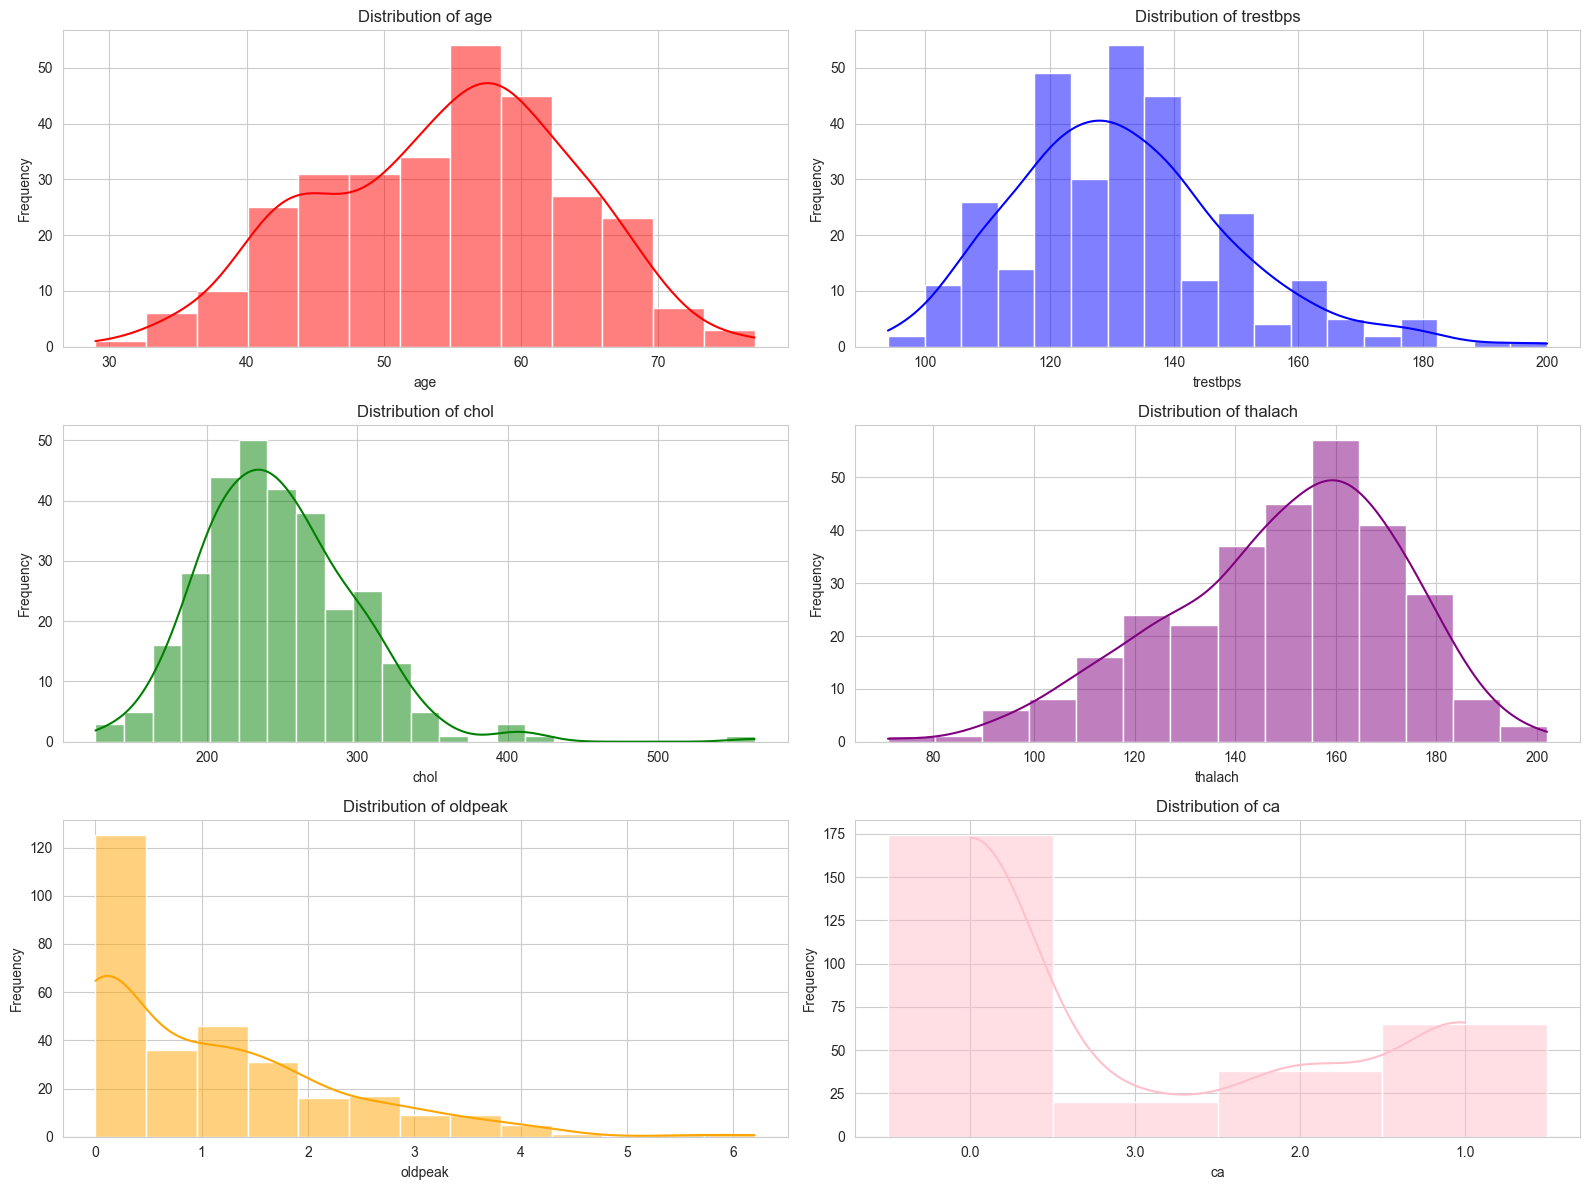

In [54]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']  # Define a list of colors for the plots

fig, axes = plt.subplots(nrows=(len(numeric_features) + 1) // 2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(numeric_features):
    sns.histplot(heart_disease[column], kde=True, bins="auto", color=colors[i % len(colors)], ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Comments
Generally it appears as all these distributions contain one primary distribution, and a secondary smaller peak. `oldpeak` and `ca` are heavily skewed to the 0 result, because there are no negative results that make sense
### Scaling required
- `age`, `trestbps`, `thalach` are approximately normally distributed so StandardScaler will work fine
- `chol` appears to be right skewed, and has some outliers, we'll need to use RobustScaler
- `oldpeak` is heavily right skewed, so we'll need to use a MinMax or QuantileTransformer
- `ca` is also heavily right skewed, so we'll need to use a MinMax or QuantileTransformer


In [58]:
scaling_encoding = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['age', 'trestbps', 'thalach']),
    ('chol', RobustScaler(), ['chol']),
    ('oldpeak', MinMaxScaler(), ['oldpeak']),
    ('ca_num', MinMaxScaler(), ['ca']),  # For numeric features of 'ca'
    ('cp', OneHotEncoder(), ['cp']),
    ('restecg', OneHotEncoder(), ['restecg']),
    ('slope', OneHotEncoder(), ['slope']),
    ('ca_cat', OneHotEncoder(), ['ca']),  # For categorical features of 'ca'
    ('thal', OneHotEncoder(), ['thal']),
    ('exang', "passthrough", ['exang']),
    ('fbs', "passthrough", ['fbs']),
    ('sex', "passthrough", ['sex']),
])

In [59]:
pipeline = Pipeline(steps=[
    ('preprocessor', scaling_encoding),
    ('classifier', LogisticRegression())
])

In [60]:
# Split data into X (features) and y (target)
X = heart_disease.drop(columns=['present']).iloc[:, 1:]  # Drop the first column (index)
y = heart_disease['present']

# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Further split training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on validation data
y_val_pred = pipeline.predict(X_val)
print("Validation Set Metrics:")
print(classification_report(y_val, y_val_pred))
print(f"Validation Accuracy: {accuracy_score(y_val, y_val_pred):.2f}")

# Evaluate the pipeline on the test data
y_test_pred = pipeline.predict(X_test)
print("\nTest Set Metrics:")
print(classification_report(y_test, y_test_pred))
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.2f}")

Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83        32
           1       0.81      0.79      0.80        28

    accuracy                           0.82        60
   macro avg       0.82      0.81      0.82        60
weighted avg       0.82      0.82      0.82        60

Validation Accuracy: 0.82

Test Set Metrics:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        32
           1       0.85      0.82      0.84        28

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60

Test Accuracy: 0.85
